In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seisbench.data as sbd
import seisbench.generate as sbg
import torch
import tqdm
from torch.utils.data import DataLoader

from seisLM.data_pipeline.augmentations import FillMissingComponents
from seisLM.evaluation.analysis import compute_separation_fuzziness
from seisLM.model.foundation.pretrained_models import (
  LitMultiDimWav2Vec2,
  MultiDimWav2Vec2ForPreTraining,
)
from seisLM.utils import project_path

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

Dataloader

1. only extract 1000 samples for each class (earthquake vs noise)
2. return meta data for each sample

In [2]:
class MetaDataKeepingSteeredGenerator(sbg.SteeredGenerator):
  def _clean_state_dict(self, state_dict):
    # Remove control information
    trace_type = state_dict["_control_"]["trace_type"]

    X, meta = state_dict["X"]
    # path_ep_distance_km = meta.get("path_ep_distance_km", np.inf)
    # path_hyp_distance_km = meta.get("path_hyp_distance_km", np.inf)

    state_dict = {
      "X": X,
      "trace_type": trace_type,
      # "path_ep_distance_km": path_ep_distance_km,
      # "path_hyp_distance_km": path_hyp_distance_km,
    }
    return state_dict


def get_loader():
  dataset_name = "InstanceCountsCombined"
  task = "1"
  num_samples_per_trace_type = 200

  dataset = sbd.__getattribute__(dataset_name)(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    missing_component="copy",
    cache=None,
  )
  metadata_df = dataset.metadata

  eval_set = "dev"
  split = dataset.get_split(eval_set)

  task_csv = (
    project_path.gitdir() + f"/data/targets/{dataset_name}/task{task}.csv"
  )
  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]

  eq_targets = task_targets[task_targets["trace_type"] == "earthquake"].head(
    num_samples_per_trace_type
  )
  noise_targets = task_targets[task_targets["trace_type"] == "noise"].head(
    num_samples_per_trace_type
  )

  task_targets = pd.concat([eq_targets, noise_targets])

  generator = MetaDataKeepingSteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
      sbg.SteeredWindow(windowlen=3001, strategy="pad"),
      sbg.ChangeDtype(np.float32),
      FillMissingComponents(),
      sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    ]
  )
  batch_size = 10
  num_workers = 2
  loader = DataLoader(
    generator,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
  )
  return loader


loader = get_loader()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_collections = {}

for model_type in ["pretrained", "random_init"]:
  model = LitMultiDimWav2Vec2.load_from_checkpoint(
    project_path.gitdir()
    +
    # '/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
    # '/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_sample_pick_false_42__2024-08-31-18h-41m-44s/checkpoints/epoch=35-step=1082700.ckpt',
    "/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_32bit_scaleup_samp_false_42__2024-09-01-23h-26m-07s/checkpoints/epoch=36-step=649091.ckpt"
  ).model

  if model_type == "random_init":
    model = MultiDimWav2Vec2ForPreTraining(model.config)

  model = model.to(device)
  model = model.eval()
  model_collections[model_type] = model
  del model

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


In [4]:
features_of_models = {}

for model_type, model in model_collections.items():
  batch_input_dict = defaultdict(list)
  batch_features_dict = defaultdict(list)

  for batch in tqdm.tqdm(loader):
    for key, value in batch.items():
      batch_input_dict[key].append(value)

    with torch.no_grad():
      input_values = batch["X"]
      wav2vec2_output = model.wav2vec2(
        input_values=input_values.cuda(),
        output_hidden_states=True,
      )

    batch_features_dict["conv_features"].append(
      wav2vec2_output.extract_features.mean(axis=1)
    )

    for hidden_states_layer_idx, hidden_states in enumerate(
      wav2vec2_output.hidden_states
    ):
      batch_features_dict[f"hidden_states_{hidden_states_layer_idx}"].append(
        hidden_states.mean(axis=1)
      )

  all_features_dict = defaultdict(list)
  all_input_values = defaultdict(list)

  for key, value in batch_features_dict.items():
    concat_features = torch.concatenate(value, axis=0).cpu().numpy()
    all_features_dict[key] = concat_features

  for key, value in batch_input_dict.items():
    if isinstance(value[0], torch.Tensor):
      concat_values = torch.cat(value, axis=0).cpu().numpy()
    elif isinstance(value[0], np.ndarray) or isinstance(value[0], list):
      concat_values = np.concatenate(value, axis=0)
    else:
      raise ValueError
    all_input_values[key] = concat_values

  features_of_models[model_type] = all_features_dict

  0%|          | 0/40 [00:00<?, ?it/s]2024-09-09 13:16:09,660 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-09 13:16:09,694 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
  0%|          | 0/40 [00:00<?, ?it/s]2024-09-09 13:16:17,005 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-09 13:16:17,042 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


In [5]:
seislm_kwargs = {
  "color": "#1b7837",
  "linestyle": "-",
  "lw": 2,
  "marker": "o",
}

random_init_seislm_kwargs = {
  "color": "gray",
  "linestyle": "--",
  "lw": 2,
  "marker": "s",
}


model_kwargs = {}
model_kwargs["pretrained"] = seislm_kwargs
model_kwargs["random_init"] = random_init_seislm_kwargs

In [6]:
features_of_models[model_type]["conv_features"].shape

(400, 256)

In [7]:
all_trace_types = all_input_values["trace_type"]

fuzziness_dict = defaultdict(list)
for model_type, _ in model_collections.items():
  for key, feature in features_of_models[model_type].items():
    # feature = scaler.fit_transform(feature)
    fuzziness = compute_separation_fuzziness(
      feature, all_trace_types, use_log_scale=False
    )
    print(model_type, key, fuzziness)
    fuzziness_dict[model_type].append(fuzziness)


Trace of SSW:  764.26, Trace of SSB:  161.25
pretrained conv_features 4.7394312635141
Trace of SSW:  213436.77, Trace of SSB:  67527.83
pretrained hidden_states_0 3.160723148149773
Trace of SSW:  193947.04, Trace of SSB:  62732.89
pretrained hidden_states_1 3.091632287141498
Trace of SSW:  221622.17, Trace of SSB:  63953.49
pretrained hidden_states_2 3.465364577899749
Trace of SSW:  248881.99, Trace of SSB:  66750.68
pretrained hidden_states_3 3.7285312770540897
Trace of SSW:  291588.62, Trace of SSB:  86134.79
pretrained hidden_states_4 3.3852597054118596
Trace of SSW:  332786.81, Trace of SSB:  98941.95
pretrained hidden_states_5 3.363455150129919
Trace of SSW:  363669.02, Trace of SSB:  89595.75
pretrained hidden_states_6 4.058998699799419
Trace of SSW:  383877.72, Trace of SSB:  89187.31
pretrained hidden_states_7 4.304174360276255
Trace of SSW:  421290.76, Trace of SSB:  90472.99
pretrained hidden_states_8 4.6565361252761575
Trace of SSW:  520597.00, Trace of SSB:  91425.87
pretra

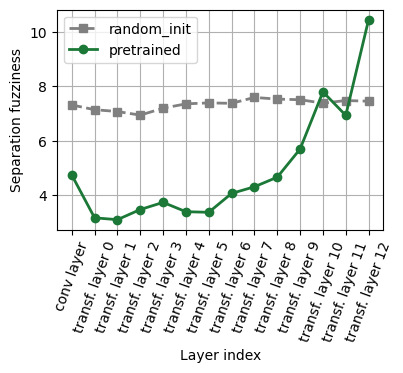

In [8]:
layer_labels = list(features_of_models[model_type].keys())

for i, layer_label in enumerate(layer_labels):
  if layer_label.startswith("conv_features"):
    layer_labels[i] = layer_label.replace("conv_features", "conv layer")
  elif layer_label.startswith("hidden_states"):
    layer_labels[i] = layer_label.replace("hidden_states_", "transf. layer ")


a4_width = 8.27
fig_width = a4_width / 2
fig_height = 1.5 * fig_width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height), sharey=True)

ax.plot(
  fuzziness_dict["random_init"],
  label="random_init",
  **random_init_seislm_kwargs,
)
ax.plot(fuzziness_dict["pretrained"], label="pretrained", **seislm_kwargs)

ax.grid()
ax.set_ylabel("Separation fuzziness")
ax.set_xlabel("Layer index")
ax.set_xticks(range(len(layer_labels)))
ax.set_xticklabels(layer_labels, rotation=70)
ax.legend()
plt.tight_layout()
# plt.subplots_adjust(left=0.1, bottom=0.5)
# fig.savefig(project_path.FIGURE_DIR + f'/separation_fuzziness.pdf')
fig.savefig(project_path.FIGURE_DIR + "/separation_fuzziness.png")


In [9]:
fuzziness_dict["random_init"]

[7.317941141732252,
 7.142933066790257,
 7.075953335612563,
 6.9431068660597655,
 7.197923841422604,
 7.359085102560924,
 7.393429261251252,
 7.37781070494521,
 7.595109797442545,
 7.533648239917273,
 7.51052607689256,
 7.384113944458541,
 7.480647705029122,
 7.455820003294689]